In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm



In [68]:
def viz(img, title=""):
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

(227, 227)


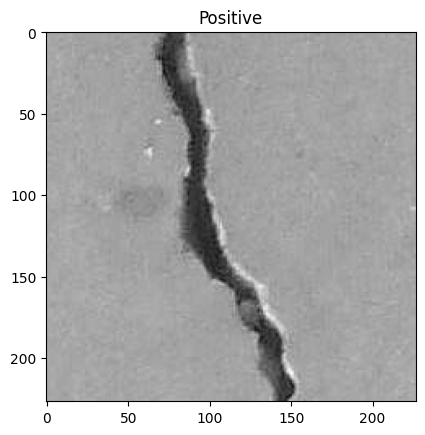

In [75]:
img_path = r"D:\fake_defect\data\archive\Positive\00001.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print(img.shape)
viz(img, "Positive")



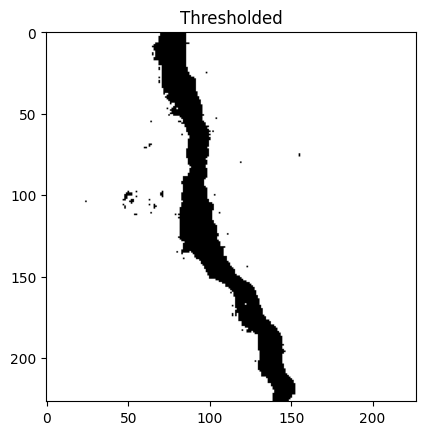

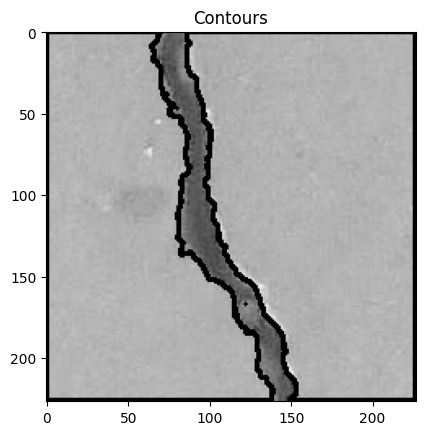

In [70]:
thr = 120
_, img_thr = cv2.threshold(img, thr, 255, cv2.THRESH_BINARY)
viz(img_thr, "Thresholded")


contours, _ = cv2.findContours(img_thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_contours = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 2)

viz(img_contours, "Contours")

In [74]:

# Set paths
save_path = r"D:\fake_defect\data\archive\masks"
positive_mask = r"D:\fake_defect\data\archive\Positive"
os.makedirs(save_path, exist_ok=True)

for file in tqdm.tqdm(os.listdir(positive_mask)):
    img_path = os.path.join(positive_mask, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        continue  
    
    img_area = img.shape[0] * img.shape[1]  
    threshold = 127  
    max_threshold = 100
    
    while threshold >= max_threshold:
        _, img_thr = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((1, 1), np.uint8)
        # Closinng
        img_thr = cv2.morphologyEx(img_thr, cv2.MORPH_CLOSE, kernel)
        # Opening
        img_thr = cv2.morphologyEx(img_thr, cv2.MORPH_OPEN, kernel)
        # Find contours
        contours, _ = cv2.findContours(img_thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        

        total_contour_area = sum(cv2.contourArea(c) for c in contours)
        
        if total_contour_area / img_area <= 0.4:
            break  
        
        threshold -= 1

    if contours:  
        max_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(img)
        
        cv2.drawContours(mask, [max_contour], -1, 0, -1)

        cv2.drawContours(mask, contours, -1, 255, -1)
        
        mask_save_path = os.path.join(save_path, file)  

        # closing and opening
        kernel = np.ones((3, 3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        

        cv2.imwrite(mask_save_path, mask)
    else:
        print(f"No contours found for {file}")


100%|██████████| 20000/20000 [01:02<00:00, 321.22it/s]
